#### Behavior of Sao Paolo traffic

## Libraries

In [0]:
%tensorflow_version 1.x

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from math import sqrt
from numpy import concatenate
from pandas import read_csv
from pandas import DataFrame
from pandas import concat

from sklearn.model_selection import train_test_split, KFold
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures, MinMaxScaler, LabelEncoder
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn import metrics, utils, preprocessing

from sklearn.externals.six import StringIO  
from IPython.display import Image  
from sklearn.tree import export_graphviz
import pydotplus

import keras
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout
from keras.layers import LSTM

from statsmodels.tsa.stattools import acf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

from google.colab import drive

plt.style.use("seaborn-whitegrid")

In [92]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [93]:
%cd /content/drive/My Drive/Colab Notebooks/Business_traffic/

/content/drive/My Drive/Colab Notebooks/Business_traffic


### Functions

In [0]:
def plot_graph(day, df):
    if day == 0:
        plt.barh(attributes, df, color='orange')
        plt.title("Total")
    else:
        plt.barh(attributes, df.loc[df.Day == day].values[0][1:])
        plt.title("Day {}".format(day))
    plt.grid(axis='x', linewidth='0.5')

In [0]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg

In [0]:
class Autoencoder():
    def __init__(self):
        
        self.img_shape = (2,18)
        
        optimizer = keras.optimizers.Adam(lr=0.000005)
        
        self.autoencoder_model = self.build_model()
        self.autoencoder_model.compile(loss='mse', optimizer=optimizer)
        self.autoencoder_model.summary()
    
    def build_model(self):
        input_layer = keras.layers.Input(shape=self.img_shape)
        h = keras.layers.BatchNormalization()(input_layer)

        h = LSTM(512)(h)
        #h = Dropout(0.2)(h)
        h = keras.layers.BatchNormalization()(h)
        # h = keras.layers.TimeDistributed(Dense(100, activation = 'relu'))(h)
        # h = keras.layers.BatchNormalization()(h)
       
        # h = LSTM(64, stateful = True)(h)
        # h = keras.layers.BatchNormalization()(h)
        # h = keras.layers.TimeDistributed(Dense(50, activation = 'relu'))(h)
        # h = keras.layers.BatchNormalization()(h)

        # h = LSTM(50, activation='relu')(h)
        # h = keras.layers.BatchNormalization()(h)
        
        h = Dense(128, activation = 'relu')(h)
        h = keras.layers.BatchNormalization()(h)
        #h = Dropout(0.2)(h)

        # h = Dense(500, activation = 'relu')(h)
        # # h = Dropout(0.5)(h)
        h = keras.layers.BatchNormalization()(h)
        # h = Dense(400, activation = 'relu')(h)
        # h = Dense(5, activation = 'relu')(h)
        # h = keras.layers.BatchNormalization()(h)
        # h = Dense(50, activation = 'relu')(h)
        output_layer = Dense(1, activation = 'hard_sigmoid')(h)
        
        return keras.models.Model(input_layer, output_layer)
    
    def train_model(self, x_train, y_train, epochs, batch_size=10):
        early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss',
                                       min_delta=0,
                                       patience=40,
                                       verbose=1, 
                                       mode='auto')
        history = self.autoencoder_model.fit(x_train, y_train,
                                             batch_size=batch_size,
                                             epochs=epochs,
                                             shuffle = True,
                                             validation_split = 0.20,
                                             callbacks=[early_stopping])
        plt.plot(history.history['loss'])
        plt.plot(history.history['val_loss'])
        plt.title('Model loss')
        plt.ylabel('Loss')
        plt.xlabel('Epoch')
        plt.legend(['Train', 'Test'], loc='upper left')
        plt.show()
        
    def eval_model(self, x_test):
        preds = self.autoencoder_model.predict(x_test)
        return preds

## Dataset

In [0]:
dataframe = pd.read_csv("dataset.csv", sep=";")

attributes = dataframe.columns.tolist()
del(attributes[len(attributes)-1], attributes[0])

dataframe.insert(0, 'Day', np.repeat([1,2,3,4,5],27))

dict_hours = {1: "7:00", 2: "7:30", 3: "8:00", 4: "8:30", 5: "9:00", 6: "9:30", 7: "10:00", 8: "10:30",
                 9: "11:00", 10: "11:30", 11: "12:00", 12: "12:30", 13: "13:00", 14: "13:30", 15: "14:00",
                 16: "14:30", 17: "15:00", 18: "15:30", 19: "16:00", 20: "16:30", 21: "17:00", 22: "17:30",
                 23: "18:00", 24: "18:30", 25: "19:00", 26: "19:30", 27: "20:00"}

In [98]:
dataframe.head()

,Day,Hour (Coded),Immobilized bus,Broken Truck,Vehicle excess,Accident victim,Running over,Fire vehicles,Occurrence involving freight,Incident involving dangerous freight,Lack of electricity,Fire,Point of flooding,Manifestations,Defect in the network of trolleybuses,Tree on the road,Semaphore off,Intermittent Semaphore,Slowness in traffic (%)
0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,"4,1"
1,1,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,"6,6"
2,1,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,"8,7"
3,1,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,"9,2"
4,1,5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,"11,1"


## Data Analysis

### Crash

In [0]:
sum_list = []
for i in range(len(attributes)):
    sum_list.append(dataframe[attributes[i]].sum())

ndays = 5
sum_day = pd.DataFrame(columns=attributes)
sum_day.insert(0, "Day", "Nan")

for n in range(1, ndays+1):
    sum_day_2 = []
    for i in range(len(attributes)):
        sum_day_2.append(dataframe[attributes[i]].loc[dataframe.Day == n].sum())
    df = pd.DataFrame([sum_day_2], columns=attributes)
    df.insert(0, "Day", n)
    sum_day = sum_day.append(df, ignore_index=True)

In [100]:
sum_day.iloc[:, 1:].head()

,Immobilized bus,Broken Truck,Vehicle excess,Accident victim,Running over,Fire vehicles,Occurrence involving freight,Incident involving dangerous freight,Lack of electricity,Fire,Point of flooding,Manifestations,Defect in the network of trolleybuses,Tree on the road,Semaphore off,Intermittent Semaphore
0,3,8,0,3,1,0,0,0,0,0,0,0,0,1,0,0
1,14,26,0,14,2,1,0,0,1,0,0,0,3,1,1,0
2,8,32,1,17,3,0,0,0,12,1,6,1,2,1,9,1
3,11,26,0,7,5,0,1,1,2,0,10,5,9,2,2,1
4,10,26,3,16,5,0,0,0,1,0,0,1,17,1,5,0


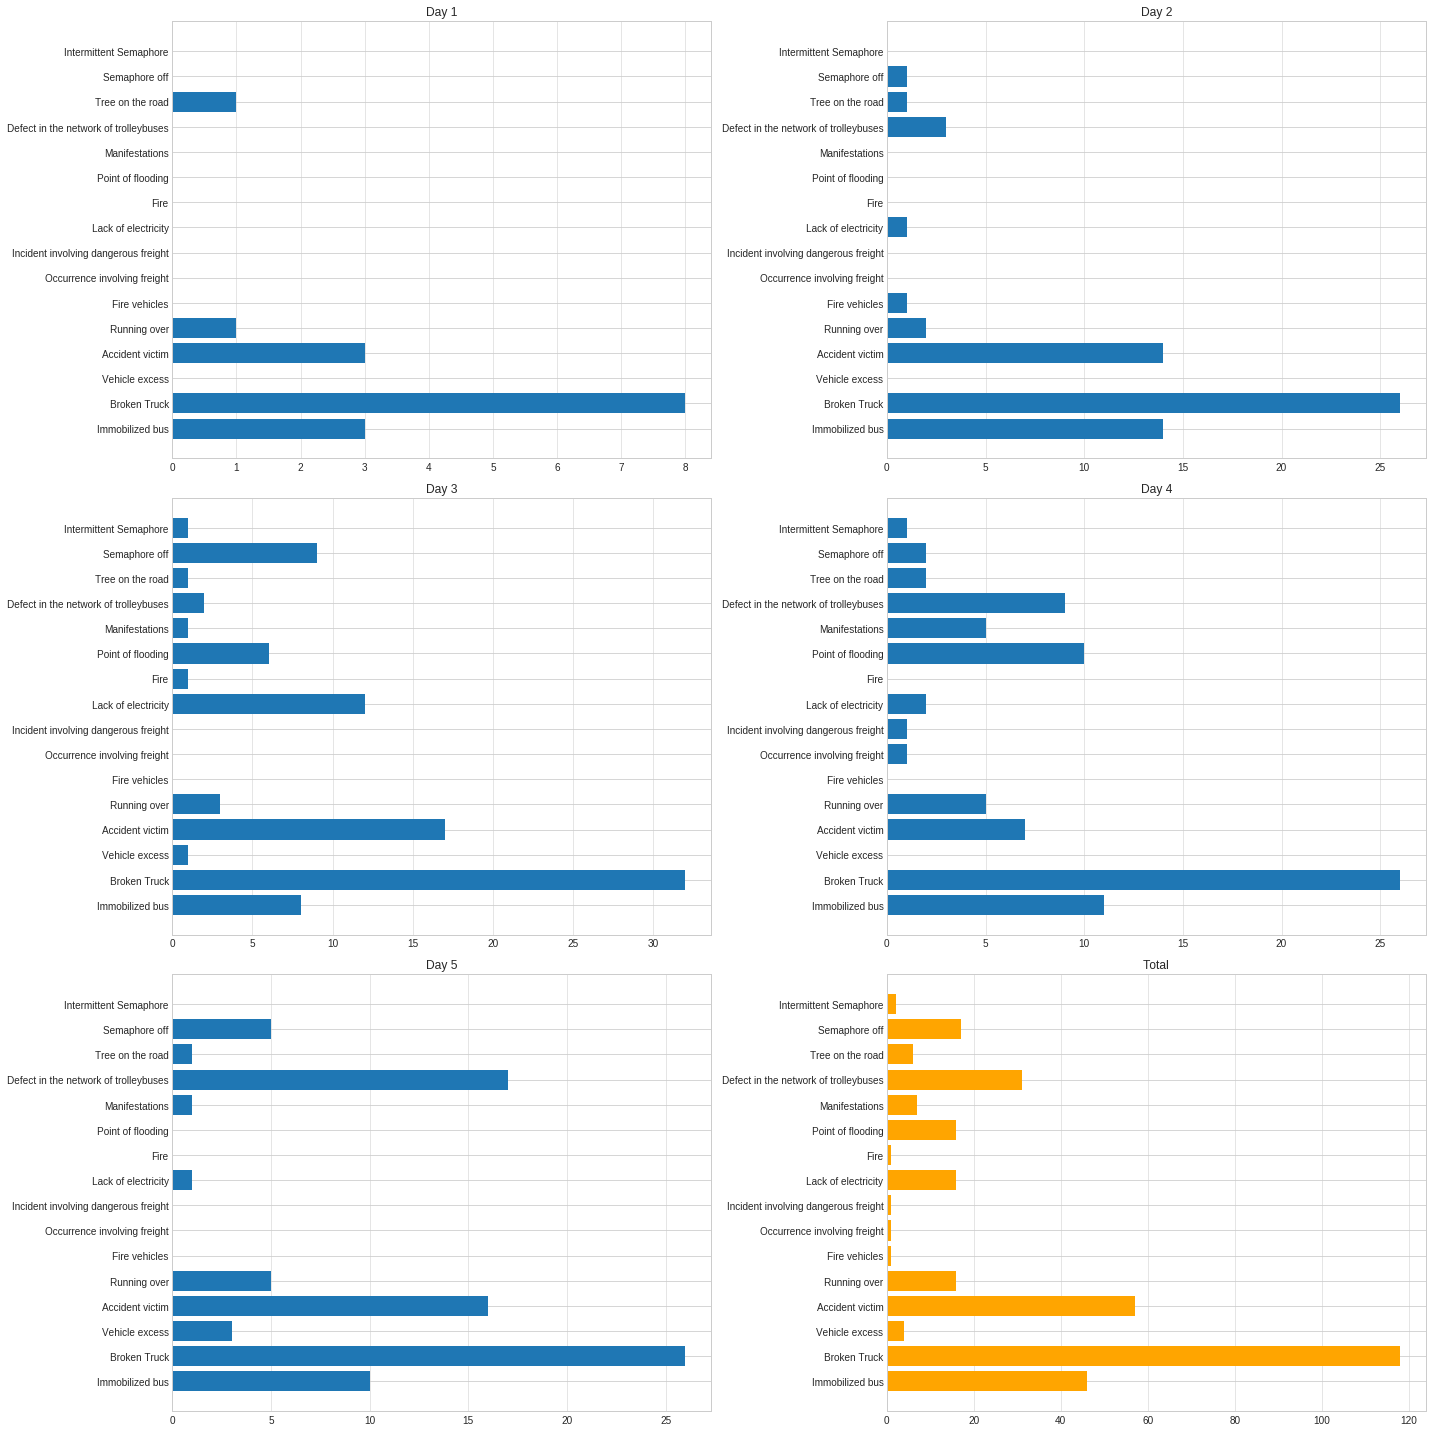

In [101]:
plt.figure(figsize=(20,20))
plt.subplot(3,2,1)
plot_graph(1, sum_day)
plt.subplot(3,2,2)
plot_graph(2, sum_day)
plt.subplot(3,2,3)
plot_graph(3, sum_day)
plt.subplot(3,2,4)
plot_graph(4, sum_day)
plt.subplot(3,2,5)
plot_graph(5, sum_day)
plt.subplot(3,2,6)
plot_graph(0, sum_list)

plt.tight_layout()

In [102]:
print(sum_list)

[46, 118, 4, 57, 16, 1, 1, 1, 16, 1, 16, 7, 31, 6, 17, 2]


In [0]:
dataframe["Slowness in traffic (%)"] = dataframe["Slowness in traffic (%)"].map(lambda x: x.replace(',', '.')) 
dataframe["Slowness in traffic (%)"] = dataframe["Slowness in traffic (%)"].astype(float)

In [104]:
dataframe.columns

Index(['Day', 'Hour (Coded)', 'Immobilized bus', 'Broken Truck',
       'Vehicle excess', 'Accident victim', 'Running over', 'Fire vehicles',
       'Occurrence involving freight', 'Incident involving dangerous freight',
       'Lack of electricity', 'Fire', 'Point of flooding', 'Manifestations',
       'Defect in the network of trolleybuses', 'Tree on the road',
       'Semaphore off', 'Intermittent Semaphore', 'Slowness in traffic (%)'],
      dtype='object')

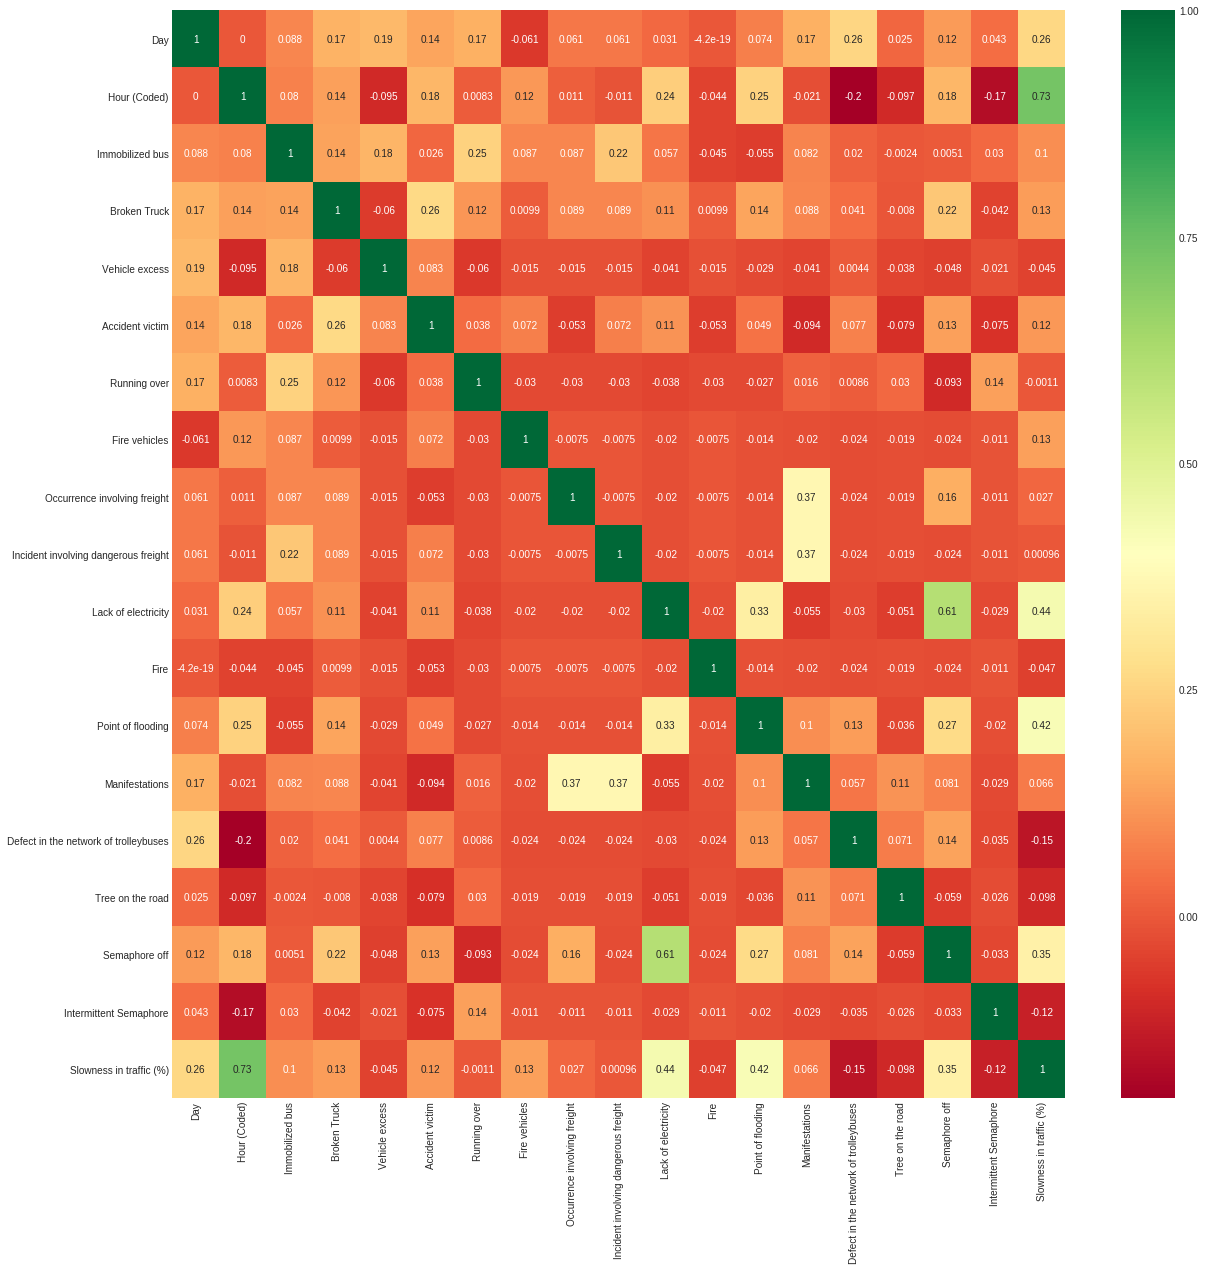

In [105]:
corrmat = dataframe.corr()
top_corr_features = corrmat.index
plt.figure(figsize=(20,20))

g=sns.heatmap(dataframe[top_corr_features].corr(),annot=True,cmap="RdYlGn")

In [106]:
corrmat["Slowness in traffic (%)"].sort_values(ascending=False)


Slowness in traffic (%)                  1.000000
Hour (Coded)                             0.729962
Lack of electricity                      0.436569
Point of flooding                        0.420016
Semaphore off                            0.347242
Day                                      0.261948
Fire vehicles                            0.134103
Broken Truck                             0.131998
Accident victim                          0.121730
Immobilized bus                          0.101143
Manifestations                           0.066377
Occurrence involving freight             0.026791
Incident involving dangerous freight     0.000957
Running over                            -0.001133
Vehicle excess                          -0.045297
Fire                                    -0.046737
Tree on the road                        -0.098489
Intermittent Semaphore                  -0.119942
Defect in the network of trolleybuses   -0.147035
Name: Slowness in traffic (%), dtype: float64

In [107]:
dataframe.shape

(135, 19)

In [108]:
dataframe.describe().T

,count,mean,std,min,25%,50%,75%,max
Day,135.0,3.000000,1.419481,1.0,2.0,3.0,4.00,5.0
Hour (Coded),135.0,14.000000,7.817890,1.0,7.0,14.0,21.00,27.0
Immobilized bus,135.0,0.340741,0.659749,0.0,0.0,0.0,1.00,4.0
Broken Truck,135.0,0.874074,1.102437,0.0,0.0,1.0,1.00,5.0
Vehicle excess,135.0,0.029630,0.170195,0.0,0.0,0.0,0.00,1.0
Accident victim,135.0,0.422222,0.696116,0.0,0.0,0.0,1.00,3.0
Running over,135.0,0.118519,0.346665,0.0,0.0,0.0,0.00,2.0
Fire vehicles,135.0,0.007407,0.086066,0.0,0.0,0.0,0.00,1.0
Occurrence involving freight,135.0,0.007407,0.086066,0.0,0.0,0.0,0.00,1.0
Incident involving dangerous freight,135.0,0.007407,0.086066,0.0,0.0,0.0,0.00,1.0


[Text(0, 0.5, 'Slowness'),
 Text(0.5, 0, 'Hour'),
 Text(0.5, 1.0, 'Slowness percent in different hours')]

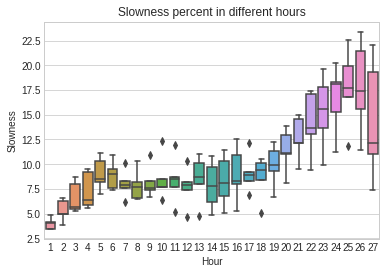

In [109]:
bx = sns.boxplot(x="Hour (Coded)", y="Slowness in traffic (%)", data = dataframe)
bx.set(xlabel='Hour', ylabel='Slowness', title="Slowness percent in different hours")

### Traffic mean time

In [0]:
df_withoutCrash = dataframe.iloc[:]
for n in range(len(df_withoutCrash)-1, -1, -1):
    if df_withoutCrash.iloc[n, 2:18].values.sum() != 0:
        df_withoutCrash.drop(n, inplace=True)

mean_time = []
mean_time_withoutCrash = []
for n in range(1, 28):
    mean_time.append(dataframe["Slowness in traffic (%)"].loc[dataframe["Hour (Coded)"] == n].mean())
    mean_time_withoutCrash.append(df_withoutCrash["Slowness in traffic (%)"].loc[df_withoutCrash["Hour (Coded)"] == n].mean())

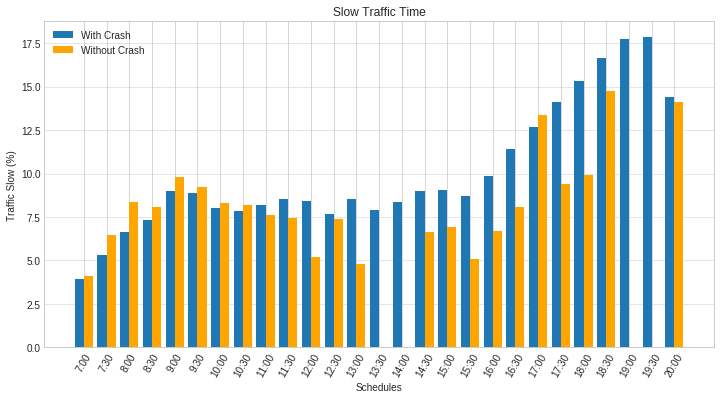

In [111]:
plt.figure(figsize=(12,6))
plt.bar(dataframe["Hour (Coded)"].unique(), mean_time,
             label="With Crash", width=0.4, align="center")
plt.bar(dataframe["Hour (Coded)"].unique()+0.4, mean_time_withoutCrash,
             label="Without Crash", color="orange", width=0.4)
plt.legend()
plt.title("Slow Traffic Time")
plt.xlabel("Schedules")
plt.ylabel("Traffic Slow (%)")
plt.xticks(dataframe["Hour (Coded)"].unique()+0.2, dict_hours.values(), rotation=60)
plt.grid(axis='y', linewidth="0.5")

Here you can see the effects of the low amount of data. For at some times, the slowness is greater without incident than when there are incidents.
However, taking into account the data, it is possible that until 11:00 am the occurrence of incidents does not affect traffic slowness so much. And from 14:30, the incidents have a greater impact on the slow traffic.

### Crash / Hour

In [0]:
mean_crash = dataframe.groupby("Hour (Coded)").mean()
crash_sum = dataframe.groupby("Hour (Coded)").sum()
mean_slow = mean_crash["Slowness in traffic (%)"]

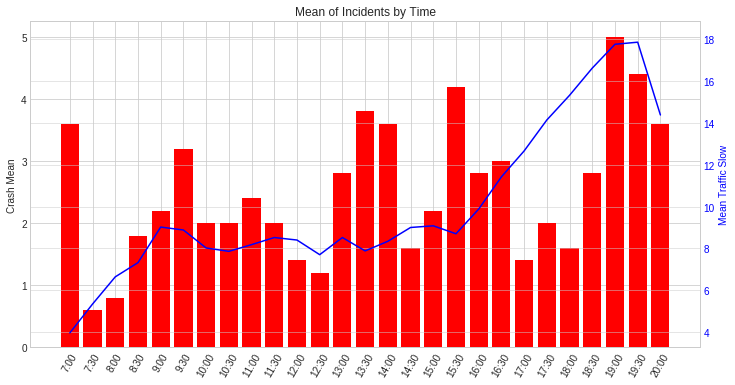

In [113]:
fig, ax1 = plt.subplots(figsize=(12,6))
for n in range(len(dict_hours)):
    ax1.bar(dict_hours[n+1], mean_crash.iloc[n, 1:17].sum(), color="red")
ax1.set_ylabel('Crash Mean')
ax2 = ax1.twinx()
ax2.plot(np.array([str(x) for x in list(dict_hours.values())]), np.array(mean_slow), color='b')
plt.ylim(top=max(mean_slow)+1)
ax2.set_ylabel('Mean Traffic Slow', color='b')
for lb in ax2.get_yticklabels():
    lb.set_color('b')
for ax in fig.axes:
    plt.sca(ax)
    plt.xticks(rotation=60)
plt.title("Mean of Incidents by Time")
plt.grid(axis='y', linewidth="0.5")

The most frequent accident periods are in the afternoon (between 13:00 and 17:00), and at night (after 19:00)

### Crash / Time

In [0]:
def plot_crash(crashed):
    crash = crash_sum[crashed]
    
    plt.figure(figsize=(12,5))
    for n in range(len(dict_hours)):
        plt.bar(dict_hours[n+1],  crash[n+1], color="grey")
    plt.xticks(rotation=60)
    plt.yticks(list(range(min(crash), max(crash)+1)))
    plt.grid(axis='y', linewidth="0.5")
    plt.title("n.'{}' per Hour".format(crashed))

Incident Options: Immobilized bus Broken Truck Vehicle excess Accident victim Running over Fire vehicles Occurrence involving freight Incident involving dangerous freight Lack of electricity Fire Point of flooding Manifestations Defect in the network of trolleybuses Tree on the road Semaphore off Intermittent Semaphore


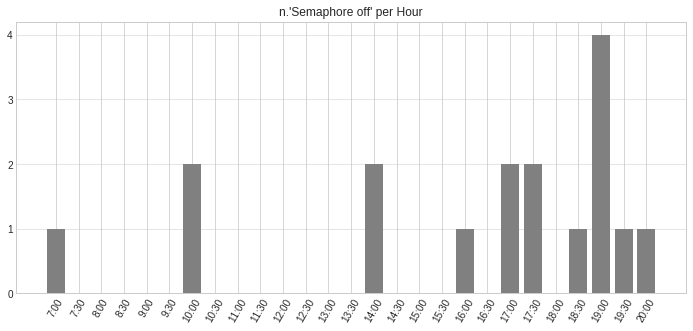

In [115]:
print("Incident Options:", *attributes)
plot_crash("Semaphore off")

"Traffic lights off" incidents have generally occurred more at a slower time. It would then be advisable to take steps to prevent this type of incident so that it may possibly slow down during the hours.

### Crash / Time _2

In [0]:
def plot_hour(hour_):
    for k, v in dict_hours.items():
        if v == hour_:
            h = k
    plt.figure(figsize=(12,5))
    plt.barh(attributes, crash_sum.iloc[h-1, 1:17].values, color="grey")
    plt.xlabel("n. Crash")
    plt.title("Time {}".format(hour_))
    plt.grid(axis='x', linewidth="0.5")

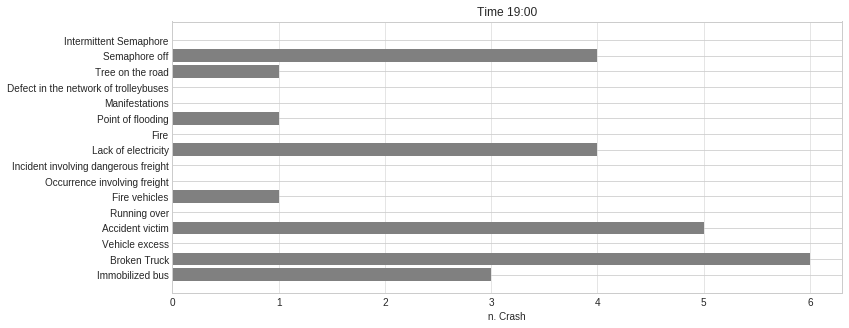

In [117]:
#print("Time Options:", *dict_hours.values(), sep='\n')
plot_hour("19:00")

### Autocorrelation

<Figure size 864x360 with 0 Axes>

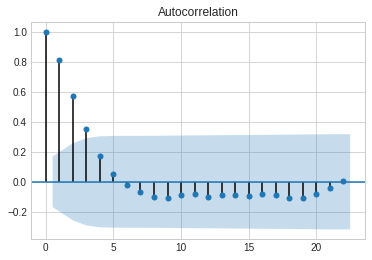

In [118]:
_ = plt.figure(figsize = (12,5))
_ = plot_acf(dataframe['Slowness in traffic (%)'].values)

## Regressor

In [119]:
dataframe

,Day,Hour (Coded),Immobilized bus,Broken Truck,Vehicle excess,Accident victim,Running over,Fire vehicles,Occurrence involving freight,Incident involving dangerous freight,Lack of electricity,Fire,Point of flooding,Manifestations,Defect in the network of trolleybuses,Tree on the road,Semaphore off,Intermittent Semaphore,Slowness in traffic (%)
0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4.1
1,1,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,6.6
2,1,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,8.7
3,1,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,9.2
4,1,5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,11.1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
130,5,23,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,17.8
131,5,24,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,18.1
132,5,25,1,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,17.7
133,5,26,0,4,0,0,0,0,0,0,0,0,0,1,0,0,1,0,17.4


In [120]:
dataframe = dataframe.drop("Day", axis=1)
x = [i for i in dataframe]
x[0] = "Hour"
AVG = dataframe[x[-1]].mean()
dataframe=dataframe.replace(to_replace=np.nan, value=AVG)

dataframe.columns = x
resultColumn = dataframe[x[-1]]
dataframe = dataframe.drop(x[-1], axis=1)
dummy = pd.get_dummies(dataframe.Hour)
merge = pd.concat([dataframe, dummy],axis=1)
dataframe = merge.drop("Hour", axis=1)
'''for i in dataframe:
    if dataframe[i].mean() <= 0.2:
        dataframe = dataframe.drop(i,axis=1)
        '''
#Normalization        
minmax = MinMaxScaler()
dataframe[[i for i in dataframe]] = minmax.fit_transform(dataframe[[i for i in dataframe]])

dataframe = pd.concat([dataframe, resultColumn], axis=1)

dataframe

,Immobilized bus,Broken Truck,Vehicle excess,Accident victim,Running over,Fire vehicles,Occurrence involving freight,Incident involving dangerous freight,Lack of electricity,Fire,Point of flooding,Manifestations,Defect in the network of trolleybuses,Tree on the road,Semaphore off,Intermittent Semaphore,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,Slowness in traffic (%)
0,0.00,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.0,0.00,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.1
1,0.00,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.0,0.00,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.6
2,0.00,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.0,0.00,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.7
3,0.00,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.0,0.00,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9.2
4,0.00,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.0,0.00,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,11.1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
130,0.25,0.0,0.0,0.000000,0.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.125,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,17.8
131,0.00,0.0,0.0,0.666667,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,18.1
132,0.25,0.0,0.0,0.666667,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,17.7
133,0.00,0.8,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.000,0.0,0.25,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,17.4


In [0]:
x_ts = dataframe.iloc[:, -28:-1].values
y_ts = dataframe.iloc[:, -1].values

x = dataframe.iloc[:, :-1].values
y = dataframe.iloc[:, -1].values

#x_nts = dataframe.iloc[:, 0:-28].values
#y_nts = dataframe.iloc[:, -1].values

In [0]:
model_compare = pd.DataFrame()

### All variables

In [0]:
X_train, X_test, y_train, y_test = train_test_split(x, y, train_size=4/5, shuffle=False)

#### Polynomial Regressor

In [124]:
poly = PolynomialFeatures(degree=1)
poly_x = poly.fit_transform(x)

regressor = LinearRegression()
regressor.fit(poly_x,y)
y_pred = regressor.predict(poly.fit_transform(X_test))


for i in range(27):
     print("○ Predicted Value: ","{0:.1f}".format(y_pred[i]),"| Actual Value: ","{0:.1f}".format(y_test[i]))

○ Predicted Value:  4.4 | Actual Value:  3.4
○ Predicted Value:  5.3 | Actual Value:  5.0
○ Predicted Value:  7.0 | Actual Value:  5.5
○ Predicted Value:  7.8 | Actual Value:  6.4
○ Predicted Value:  8.2 | Actual Value:  8.2
○ Predicted Value:  10.1 | Actual Value:  9.0
○ Predicted Value:  8.1 | Actual Value:  10.1
○ Predicted Value:  8.1 | Actual Value:  10.3
○ Predicted Value:  8.4 | Actual Value:  10.9
○ Predicted Value:  8.7 | Actual Value:  12.3
○ Predicted Value:  8.5 | Actual Value:  11.9
○ Predicted Value:  8.8 | Actual Value:  10.3
○ Predicted Value:  8.3 | Actual Value:  11.0
○ Predicted Value:  7.8 | Actual Value:  9.7
○ Predicted Value:  7.5 | Actual Value:  10.3
○ Predicted Value:  9.9 | Actual Value:  10.9
○ Predicted Value:  8.8 | Actual Value:  8.9
○ Predicted Value:  8.5 | Actual Value:  9.4
○ Predicted Value:  10.2 | Actual Value:  11.3
○ Predicted Value:  11.7 | Actual Value:  13.0
○ Predicted Value:  12.2 | Actual Value:  14.6
○ Predicted Value:  14.2 | Actual Value

In [125]:
print('MAE:', metrics.mean_absolute_error(y_test, y_pred))
print('MSE:', metrics.mean_squared_error(y_test, y_pred))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
print('R2:', metrics.r2_score(y_test, y_pred))

MAE: 1.6830982349537038
MSE: 3.916365223990547
RMSE: 1.9789808548822667
R2: 0.7426583830023734


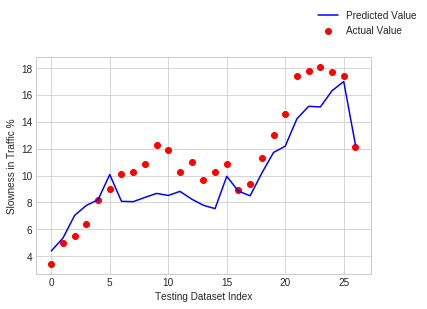

In [126]:
assume = [i for i in range(27)]
plt.scatter(assume,y_test,c='r',label="Actual Value")
plt.plot(assume, y_pred, color = 'blue',label="Predicted Value")
plt.ylabel("Slowness in Traffic %")
plt.xlabel("Testing Dataset Index")
plt.legend(loc=1,borderaxespad=-5)
plt.show()

In [0]:
model_name = "Polynomial Regressor"
model_compare.loc[0,'Model Name'] = model_name + " all"

model_compare.loc[0, 'R2'] = float(metrics.r2_score(y_test, y_pred))
model_compare.loc[0, 'MAE'] = float(metrics.mean_absolute_error(y_test, y_pred))
model_compare.loc[0, 'MSE'] = float(metrics.mean_squared_error(y_test, y_pred))
model_compare.loc[0, 'RMSE'] = float(np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

#### Decision Tree Regressor

In [128]:
regressor = DecisionTreeRegressor(random_state =1)
regressor.fit(X_train, y_train)

y_pred = regressor.predict(X_test)

for i in range(27):
     print("○ Predicted Value: ","{0:.1f}".format(y_pred[i]),"| Actual Value: ","{0:.1f}".format(y_test[i]))

○ Predicted Value:  4.0 | Actual Value:  3.4
○ Predicted Value:  5.0 | Actual Value:  5.0
○ Predicted Value:  5.3 | Actual Value:  5.5
○ Predicted Value:  10.5 | Actual Value:  6.4
○ Predicted Value:  10.3 | Actual Value:  8.2
○ Predicted Value:  9.2 | Actual Value:  9.0
○ Predicted Value:  12.5 | Actual Value:  10.1
○ Predicted Value:  7.8 | Actual Value:  10.3
○ Predicted Value:  7.8 | Actual Value:  10.9
○ Predicted Value:  7.5 | Actual Value:  12.3
○ Predicted Value:  5.1 | Actual Value:  11.9
○ Predicted Value:  8.1 | Actual Value:  10.3
○ Predicted Value:  10.5 | Actual Value:  11.0
○ Predicted Value:  10.5 | Actual Value:  9.7
○ Predicted Value:  4.9 | Actual Value:  10.3
○ Predicted Value:  6.7 | Actual Value:  10.9
○ Predicted Value:  9.2 | Actual Value:  8.9
○ Predicted Value:  5.1 | Actual Value:  9.4
○ Predicted Value:  6.7 | Actual Value:  11.3
○ Predicted Value:  8.1 | Actual Value:  13.0
○ Predicted Value:  12.1 | Actual Value:  14.6
○ Predicted Value:  17.1 | Actual Val

In [129]:
'''dot_data = StringIO()

export_graphviz(regressor, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True)

graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())'''

'dot_data = StringIO()\n\nexport_graphviz(regressor, out_file=dot_data,  \n                filled=True, rounded=True,\n                special_characters=True)\n\ngraph = pydotplus.graph_from_dot_data(dot_data.getvalue())  \nImage(graph.create_png())'

In [130]:
print('MAE:', metrics.mean_absolute_error(y_test, y_pred))
print('MSE:', metrics.mean_squared_error(y_test, y_pred))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
print('R2:', metrics.r2_score(y_test, y_pred))

MAE: 2.753703703703704
MSE: 11.490833333333338
RMSE: 3.389813170859618
R2: 0.2449453864680302


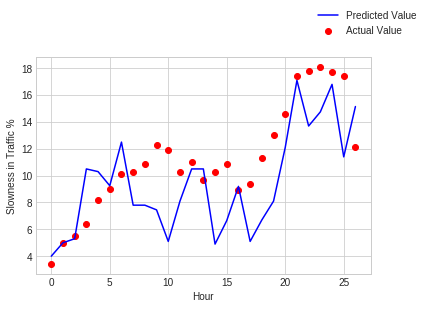

In [131]:
assume = [i for i in range(27)]
plt.scatter(assume,y_test,c='r',label="Actual Value")
plt.plot(assume, y_pred, color = 'blue',label="Predicted Value")
plt.ylabel("Slowness in Traffic %")
plt.xlabel("Hour")
plt.legend(loc=1,borderaxespad=-5)
plt.show()

In [0]:
model_name = "Decision Tree Regressor"
model_compare.loc[1,'Model Name'] = model_name + " all"

model_compare.loc[1, 'R2'] = float(metrics.r2_score(y_test, y_pred))
model_compare.loc[1, 'MAE'] = float(metrics.mean_absolute_error(y_test, y_pred))
model_compare.loc[1, 'MSE'] = float(metrics.mean_squared_error(y_test, y_pred))
model_compare.loc[1, 'RMSE'] = float(np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

#### Random Forest Regressor

In [133]:
regressor = RandomForestRegressor()
regressor.fit(X_train, y_train)
y_pred = regressor.predict(X_test)
for i in range(27):
  print("○ Predicted Value: ","{0:.1f}".format(y_pred[i]),"| Actual Value: ","{0:.1f}".format(y_test[i]))

○ Predicted Value:  5.2 | Actual Value:  3.4
○ Predicted Value:  5.6 | Actual Value:  5.0
○ Predicted Value:  7.2 | Actual Value:  5.5
○ Predicted Value:  9.1 | Actual Value:  6.4
○ Predicted Value:  8.8 | Actual Value:  8.2
○ Predicted Value:  8.8 | Actual Value:  9.0
○ Predicted Value:  10.3 | Actual Value:  10.1
○ Predicted Value:  7.5 | Actual Value:  10.3
○ Predicted Value:  7.1 | Actual Value:  10.9
○ Predicted Value:  7.6 | Actual Value:  12.3
○ Predicted Value:  6.6 | Actual Value:  11.9
○ Predicted Value:  7.2 | Actual Value:  10.3
○ Predicted Value:  7.6 | Actual Value:  11.0
○ Predicted Value:  8.3 | Actual Value:  9.7
○ Predicted Value:  8.0 | Actual Value:  10.3
○ Predicted Value:  9.7 | Actual Value:  10.9
○ Predicted Value:  9.1 | Actual Value:  8.9
○ Predicted Value:  8.0 | Actual Value:  9.4
○ Predicted Value:  8.7 | Actual Value:  11.3
○ Predicted Value:  9.1 | Actual Value:  13.0
○ Predicted Value:  11.3 | Actual Value:  14.6
○ Predicted Value:  14.3 | Actual Value: 

In [134]:
print('MAE:', metrics.mean_absolute_error(y_test, y_pred))
print('MSE:', metrics.mean_squared_error(y_test, y_pred))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
print('R2:', metrics.r2_score(y_test, y_pred))

MAE: 2.4288070987654318
MSE: 8.11102094244084
RMSE: 2.8479854182282676
R2: 0.46703049244664185


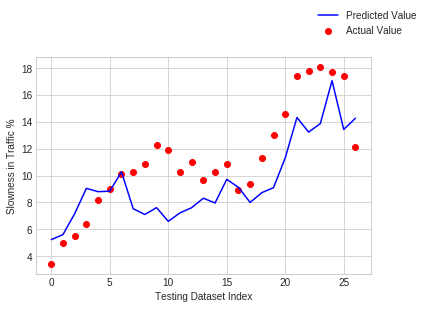

In [135]:
assume = [i for i in range(27)]
plt.scatter(assume,y_test,c='r',label="Actual Value")
plt.plot(assume, y_pred, color = 'blue',label="Predicted Value")
plt.ylabel("Slowness in Traffic %")
plt.xlabel("Testing Dataset Index")
plt.legend(loc=1,borderaxespad=-5)
plt.show()

In [0]:
model_name = "Random Forest Regressor"
model_compare.loc[2,'Model Name'] = model_name + " all"

model_compare.loc[2, 'R2'] = float(metrics.r2_score(y_test, y_pred))
model_compare.loc[2, 'MAE'] = float(metrics.mean_absolute_error(y_test, y_pred))
model_compare.loc[2, 'MSE'] = float(metrics.mean_squared_error(y_test, y_pred))
model_compare.loc[2, 'RMSE'] = float(np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

#### MLP Regressor

In [137]:
regressor = MLPRegressor(hidden_layer_sizes=(10, ), learning_rate='constant', learning_rate_init=0.01, momentum=0.75, max_iter=150)
regressor.fit(X_train, y_train)
y_pred = regressor.predict(X_test)
for i in range(27):
  print("○ Predicted Value: ","{0:.1f}".format(y_pred[i]),"| Actual Value: ","{0:.1f}".format(y_test[i]))

○ Predicted Value:  6.2 | Actual Value:  3.4
○ Predicted Value:  5.6 | Actual Value:  5.0
○ Predicted Value:  7.9 | Actual Value:  5.5
○ Predicted Value:  10.0 | Actual Value:  6.4
○ Predicted Value:  9.3 | Actual Value:  8.2
○ Predicted Value:  10.4 | Actual Value:  9.0
○ Predicted Value:  7.7 | Actual Value:  10.1
○ Predicted Value:  8.0 | Actual Value:  10.3
○ Predicted Value:  7.5 | Actual Value:  10.9
○ Predicted Value:  6.9 | Actual Value:  12.3
○ Predicted Value:  8.0 | Actual Value:  11.9
○ Predicted Value:  8.1 | Actual Value:  10.3
○ Predicted Value:  6.9 | Actual Value:  11.0
○ Predicted Value:  5.9 | Actual Value:  9.7
○ Predicted Value:  9.0 | Actual Value:  10.3
○ Predicted Value:  10.2 | Actual Value:  10.9
○ Predicted Value:  8.9 | Actual Value:  8.9
○ Predicted Value:  8.9 | Actual Value:  9.4
○ Predicted Value:  9.9 | Actual Value:  11.3
○ Predicted Value:  10.0 | Actual Value:  13.0
○ Predicted Value:  11.1 | Actual Value:  14.6
○ Predicted Value:  13.7 | Actual Valu

/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (150) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


In [138]:
print('MAE:', metrics.mean_absolute_error(y_test, y_pred))
print('MSE:', metrics.mean_squared_error(y_test, y_pred))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
print('R2:', metrics.r2_score(y_test, y_pred))

MAE: 2.481003410738009
MSE: 8.323409436039617
RMSE: 2.8850319644745044
R2: 0.45307459322672494


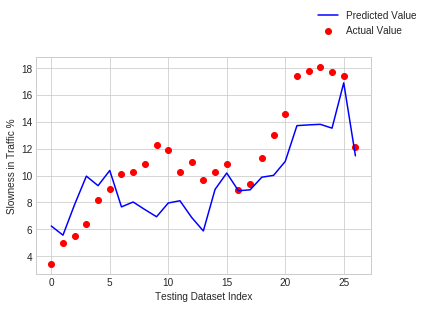

In [139]:
assume = [i for i in range(27)]
plt.scatter(assume,y_test,c='r',label="Actual Value")
plt.plot(assume, y_pred, color = 'blue',label="Predicted Value")
plt.ylabel("Slowness in Traffic %")
plt.xlabel("Testing Dataset Index")
plt.legend(loc=1,borderaxespad=-5)
plt.show()

In [0]:
model_name = "MLP Regressor"
model_compare.loc[3,'Model Name'] = model_name + " all"

model_compare.loc[3, 'R2'] = float(metrics.r2_score(y_test, y_pred))
model_compare.loc[3, 'MAE'] = float(metrics.mean_absolute_error(y_test, y_pred))
model_compare.loc[3, 'MSE'] = float(metrics.mean_squared_error(y_test, y_pred))
model_compare.loc[3, 'RMSE'] = float(np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (150) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (150) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (150) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (150) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


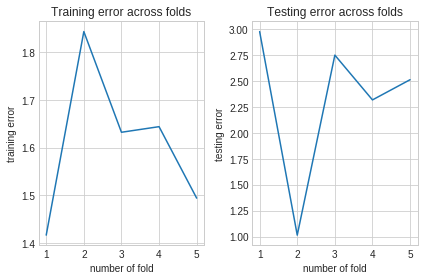

In [141]:
kf = KFold(n_splits=5)
list_training_error = []
list_testing_error = []

for train_index, test_index in kf.split(x):
   X_train, X_test = x[train_index], x[test_index]
   y_train, y_test = y[train_index], y[test_index]
   model = MLPRegressor(hidden_layer_sizes=(10, ), learning_rate='constant', learning_rate_init=0.01, momentum=0.75, max_iter=150)
   model.fit(X_train, y_train)
   y_train_data_pred = model.predict(X_train)
   y_test_data_pred = model.predict(X_test) 

   fold_training_error = mean_absolute_error(y_train, y_train_data_pred)        
   fold_testing_error = mean_absolute_error(y_test, y_test_data_pred)
   list_training_error.append(fold_training_error)
   list_testing_error.append(fold_testing_error)

plt.subplot(1,2,1)
plt.plot(range(1, kf.get_n_splits() + 1), np.array(list_training_error).ravel())
plt.xlabel('number of fold')
plt.ylabel('training error')
plt.title('Training error across folds')
plt.tight_layout()

plt.subplot(1,2,2)
plt.plot(range(1, kf.get_n_splits() + 1), np.array(list_testing_error).ravel())
plt.xlabel('number of fold')
plt.ylabel('testing error')
plt.title('Testing error across folds')
plt.tight_layout()
plt.show()

### Hour Variable

In [0]:
X_train, X_test, y_train, y_test = train_test_split(x_ts, y_ts, train_size=4/5, shuffle=False)

#### Polynomial Regressor

In [143]:
poly = PolynomialFeatures(degree=1)
poly_x = poly.fit_transform(x_ts)

regressor = LinearRegression()
regressor.fit(poly_x,y)
y_pred = regressor.predict(poly.fit_transform(X_test))


for i in range(27):
     print("○ Predicted Value: ","{0:.1f}".format(y_pred[i]),"| Actual Value: ","{0:.1f}".format(y_test[i]))

○ Predicted Value:  4.0 | Actual Value:  3.4
○ Predicted Value:  5.4 | Actual Value:  5.0
○ Predicted Value:  6.4 | Actual Value:  5.5
○ Predicted Value:  7.3 | Actual Value:  6.4
○ Predicted Value:  9.1 | Actual Value:  8.2
○ Predicted Value:  8.9 | Actual Value:  9.0
○ Predicted Value:  8.0 | Actual Value:  10.1
○ Predicted Value:  7.8 | Actual Value:  10.3
○ Predicted Value:  8.2 | Actual Value:  10.9
○ Predicted Value:  8.5 | Actual Value:  12.3
○ Predicted Value:  8.4 | Actual Value:  11.9
○ Predicted Value:  7.7 | Actual Value:  10.3
○ Predicted Value:  8.6 | Actual Value:  11.0
○ Predicted Value:  7.9 | Actual Value:  9.7
○ Predicted Value:  8.4 | Actual Value:  10.3
○ Predicted Value:  9.0 | Actual Value:  10.9
○ Predicted Value:  9.1 | Actual Value:  8.9
○ Predicted Value:  8.7 | Actual Value:  9.4
○ Predicted Value:  9.9 | Actual Value:  11.3
○ Predicted Value:  11.4 | Actual Value:  13.0
○ Predicted Value:  12.6 | Actual Value:  14.6
○ Predicted Value:  14.2 | Actual Value: 

In [144]:
print('MAE:', metrics.mean_absolute_error(y_test, y_pred))
print('MSE:', metrics.mean_squared_error(y_test, y_pred))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
print('R2:', metrics.r2_score(y_test, y_pred))

MAE: 1.6601851851851852
MSE: 3.8160521556712976
RMSE: 1.9534718210589315
R2: 0.7492498844918503


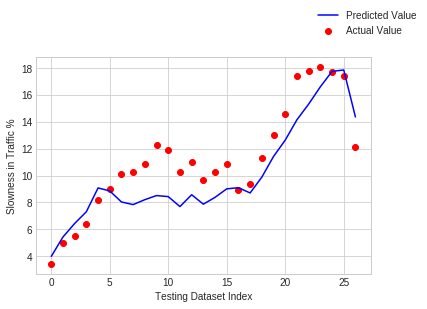

In [145]:
assume = [i for i in range(27)]
plt.scatter(assume,y_test,c='r',label="Actual Value")
plt.plot(assume, y_pred, color = 'blue',label="Predicted Value")
plt.ylabel("Slowness in Traffic %")
plt.xlabel("Testing Dataset Index")
plt.legend(loc=1,borderaxespad=-5)
plt.show()

In [0]:
model_name = "Polynomial Regressor"
model_compare.loc[4,'Model Name'] = model_name + " hour"

model_compare.loc[4, 'R2'] = float(metrics.r2_score(y_test, y_pred))
model_compare.loc[4, 'MAE'] = float(metrics.mean_absolute_error(y_test, y_pred))
model_compare.loc[4, 'MSE'] = float(metrics.mean_squared_error(y_test, y_pred))
model_compare.loc[4, 'RMSE'] = float(np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

#### Decision Tree Regressor

In [147]:
regressor = DecisionTreeRegressor(random_state=1)
regressor.fit(X_train, y_train)

y_pred = regressor.predict(X_test)

for i in range(27):
     print("○ Predicted Value: ","{0:.1f}".format(y_pred[i]),"| Actual Value: ","{0:.1f}".format(y_test[i]))

○ Predicted Value:  4.1 | Actual Value:  3.4
○ Predicted Value:  5.4 | Actual Value:  5.0
○ Predicted Value:  6.9 | Actual Value:  5.5
○ Predicted Value:  7.5 | Actual Value:  6.4
○ Predicted Value:  9.2 | Actual Value:  8.2
○ Predicted Value:  8.8 | Actual Value:  9.0
○ Predicted Value:  7.5 | Actual Value:  10.1
○ Predicted Value:  7.2 | Actual Value:  10.3
○ Predicted Value:  7.5 | Actual Value:  10.9
○ Predicted Value:  7.6 | Actual Value:  12.3
○ Predicted Value:  7.5 | Actual Value:  11.9
○ Predicted Value:  7.0 | Actual Value:  10.3
○ Predicted Value:  7.9 | Actual Value:  11.0
○ Predicted Value:  7.4 | Actual Value:  9.7
○ Predicted Value:  7.8 | Actual Value:  10.3
○ Predicted Value:  8.5 | Actual Value:  10.9
○ Predicted Value:  9.1 | Actual Value:  8.9
○ Predicted Value:  8.5 | Actual Value:  9.4
○ Predicted Value:  9.5 | Actual Value:  11.3
○ Predicted Value:  11.0 | Actual Value:  13.0
○ Predicted Value:  12.2 | Actual Value:  14.6
○ Predicted Value:  13.3 | Actual Value: 

In [148]:
print('MAE:', metrics.mean_absolute_error(y_test, y_pred))
print('MSE:', metrics.mean_squared_error(y_test, y_pred))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
print('R2:', metrics.r2_score(y_test, y_pred))

MAE: 2.0842592592592597
MSE: 6.037847222222223
RMSE: 2.4572031300285744
R2: 0.6032572861608463


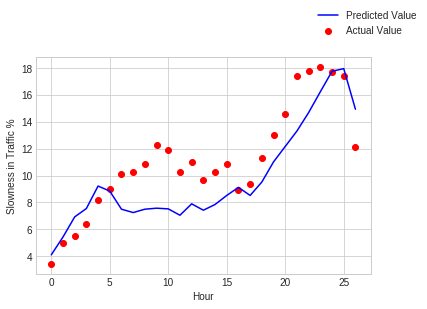

In [149]:
assume = [i for i in range(27)]
plt.scatter(assume,y_test,c='r',label="Actual Value")
plt.plot(assume, y_pred, color = 'blue',label="Predicted Value")
plt.ylabel("Slowness in Traffic %")
plt.xlabel("Hour")
plt.legend(loc=1,borderaxespad=-5)
plt.show()

In [0]:
model_name = "Decision Tree Regressor"
model_compare.loc[5,'Model Name'] = model_name + " hour"

model_compare.loc[5, 'R2'] = float(metrics.r2_score(y_test, y_pred))
model_compare.loc[5, 'MAE'] = float(metrics.mean_absolute_error(y_test, y_pred))
model_compare.loc[5, 'MSE'] = float(metrics.mean_squared_error(y_test, y_pred))
model_compare.loc[5, 'RMSE'] = float(np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

#### Random Forest Regressor

In [151]:
regressor = RandomForestRegressor()
regressor.fit(X_train, y_train)
y_pred = regressor.predict(X_test)
for i in range(27):
  print("○ Predicted Value: ","{0:.1f}".format(y_pred[i]),"| Actual Value: ","{0:.1f}".format(y_test[i]))

○ Predicted Value:  4.1 | Actual Value:  3.4
○ Predicted Value:  5.4 | Actual Value:  5.0
○ Predicted Value:  7.0 | Actual Value:  5.5
○ Predicted Value:  7.5 | Actual Value:  6.4
○ Predicted Value:  9.2 | Actual Value:  8.2
○ Predicted Value:  8.8 | Actual Value:  9.0
○ Predicted Value:  7.5 | Actual Value:  10.1
○ Predicted Value:  7.3 | Actual Value:  10.3
○ Predicted Value:  7.5 | Actual Value:  10.9
○ Predicted Value:  7.6 | Actual Value:  12.3
○ Predicted Value:  7.4 | Actual Value:  11.9
○ Predicted Value:  7.0 | Actual Value:  10.3
○ Predicted Value:  7.7 | Actual Value:  11.0
○ Predicted Value:  7.8 | Actual Value:  9.7
○ Predicted Value:  8.0 | Actual Value:  10.3
○ Predicted Value:  8.3 | Actual Value:  10.9
○ Predicted Value:  8.9 | Actual Value:  8.9
○ Predicted Value:  8.5 | Actual Value:  9.4
○ Predicted Value:  9.3 | Actual Value:  11.3
○ Predicted Value:  11.3 | Actual Value:  13.0
○ Predicted Value:  12.1 | Actual Value:  14.6
○ Predicted Value:  13.3 | Actual Value: 

In [152]:
print('MAE:', metrics.mean_absolute_error(y_test, y_pred))
print('MSE:', metrics.mean_squared_error(y_test, y_pred))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
print('R2:', metrics.r2_score(y_test, y_pred))

MAE: 2.125924307893752
MSE: 6.315030495999826
RMSE: 2.5129724423478716
R2: 0.5850437672985931


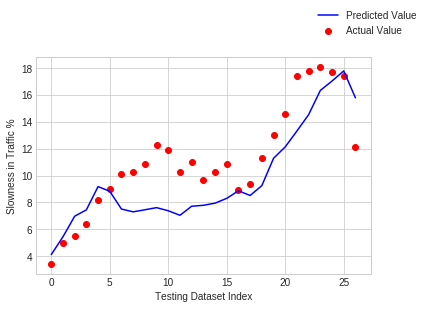

In [153]:
assume = [i for i in range(27)]
plt.scatter(assume,y_test,c='r',label="Actual Value")
plt.plot(assume, y_pred, color = 'blue',label="Predicted Value")
plt.ylabel("Slowness in Traffic %")
plt.xlabel("Testing Dataset Index")
plt.legend(loc=1,borderaxespad=-5)
plt.show()

In [0]:
model_name = "Random Forest Regressor"
model_compare.loc[6,'Model Name'] = model_name + " hour"

model_compare.loc[6, 'R2'] = float(metrics.r2_score(y_test, y_pred))
model_compare.loc[6, 'MAE'] = float(metrics.mean_absolute_error(y_test, y_pred))
model_compare.loc[6, 'MSE'] = float(metrics.mean_squared_error(y_test, y_pred))
model_compare.loc[6, 'RMSE'] = float(np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

#### MLP Regressor

In [155]:
regressor = MLPRegressor(hidden_layer_sizes=(10, ), learning_rate='constant', learning_rate_init=0.01, momentum=0.75, max_iter=150)
regressor.fit(X_train, y_train)
y_pred = regressor.predict(X_test)
for i in range(27):
  print("○ Predicted Value: ","{0:.1f}".format(y_pred[i]),"| Actual Value: ","{0:.1f}".format(y_test[i]))

○ Predicted Value:  4.1 | Actual Value:  3.4
○ Predicted Value:  5.5 | Actual Value:  5.0
○ Predicted Value:  7.0 | Actual Value:  5.5
○ Predicted Value:  7.7 | Actual Value:  6.4
○ Predicted Value:  9.5 | Actual Value:  8.2
○ Predicted Value:  9.1 | Actual Value:  9.0
○ Predicted Value:  7.6 | Actual Value:  10.1
○ Predicted Value:  7.4 | Actual Value:  10.3
○ Predicted Value:  7.6 | Actual Value:  10.9
○ Predicted Value:  7.7 | Actual Value:  12.3
○ Predicted Value:  7.6 | Actual Value:  11.9
○ Predicted Value:  7.1 | Actual Value:  10.3
○ Predicted Value:  8.0 | Actual Value:  11.0
○ Predicted Value:  7.5 | Actual Value:  9.7
○ Predicted Value:  8.0 | Actual Value:  10.3
○ Predicted Value:  8.7 | Actual Value:  10.9
○ Predicted Value:  9.4 | Actual Value:  8.9
○ Predicted Value:  8.7 | Actual Value:  9.4
○ Predicted Value:  9.8 | Actual Value:  11.3
○ Predicted Value:  11.4 | Actual Value:  13.0
○ Predicted Value:  12.6 | Actual Value:  14.6
○ Predicted Value:  13.8 | Actual Value: 

/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (150) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


In [156]:
print('MAE:', metrics.mean_absolute_error(y_test, y_pred))
print('MSE:', metrics.mean_squared_error(y_test, y_pred))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
print('R2:', metrics.r2_score(y_test, y_pred))

MAE: 2.1131756548040745
MSE: 5.88248397409816
RMSE: 2.425383263341726
R2: 0.6134660964243361


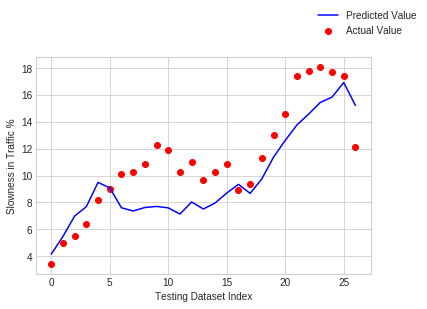

In [157]:
assume = [i for i in range(27)]
plt.scatter(assume,y_test,c='r',label="Actual Value")
plt.plot(assume, y_pred, color = 'blue',label="Predicted Value")
plt.ylabel("Slowness in Traffic %")
plt.xlabel("Testing Dataset Index")
plt.legend(loc=1,borderaxespad=-5)
plt.show()

In [0]:
model_name = "MLP Regressor"
model_compare.loc[7,'Model Name'] = model_name + " hour"

model_compare.loc[7, 'R2'] = float(metrics.r2_score(y_test, y_pred))
model_compare.loc[7, 'MAE'] = float(metrics.mean_absolute_error(y_test, y_pred))
model_compare.loc[7, 'MSE'] = float(metrics.mean_squared_error(y_test, y_pred))
model_compare.loc[7, 'RMSE'] = float(np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (150) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (150) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (150) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (150) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


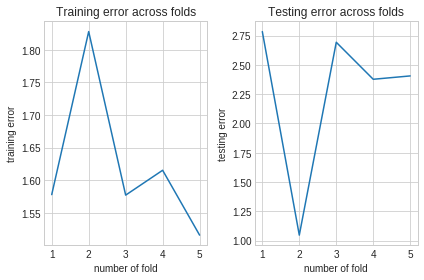

In [159]:
kf = KFold(n_splits=5)
list_training_error = []
list_testing_error = []

for train_index, test_index in kf.split(x):
   X_train, X_test = x[train_index], x[test_index]
   y_train, y_test = y[train_index], y[test_index]
   model = MLPRegressor(hidden_layer_sizes=(10, ), learning_rate='constant', learning_rate_init=0.01, momentum=0.75, max_iter=150)
   model.fit(X_train, y_train)
   y_train_data_pred = model.predict(X_train)
   y_test_data_pred = model.predict(X_test) 

   fold_training_error = mean_absolute_error(y_train, y_train_data_pred)        
   fold_testing_error = mean_absolute_error(y_test, y_test_data_pred)
   list_training_error.append(fold_training_error)
   list_testing_error.append(fold_testing_error)

plt.subplot(1,2,1)
plt.plot(range(1, kf.get_n_splits() + 1), np.array(list_training_error).ravel())
plt.xlabel('number of fold')
plt.ylabel('training error')
plt.title('Training error across folds')
plt.tight_layout()

plt.subplot(1,2,2)
plt.plot(range(1, kf.get_n_splits() + 1), np.array(list_testing_error).ravel())
plt.xlabel('number of fold')
plt.ylabel('testing error')
plt.title('Testing error across folds')
plt.tight_layout()
plt.show()

### Evaluation

In [0]:
model_compare.sort_values(by = ['R2'], ascending=False, inplace=True)

In [161]:
print(model_compare)

                     Model Name        R2       MAE        MSE      RMSE
4     Polynomial Regressor hour  0.749250  1.660185   3.816052  1.953472
0      Polynomial Regressor all  0.742658  1.683098   3.916365  1.978981
7            MLP Regressor hour  0.613466  2.113176   5.882484  2.425383
5  Decision Tree Regressor hour  0.603257  2.084259   6.037847  2.457203
6  Random Forest Regressor hour  0.585044  2.125924   6.315030  2.512972
2   Random Forest Regressor all  0.467030  2.428807   8.111021  2.847985
3             MLP Regressor all  0.453075  2.481003   8.323409  2.885032
1   Decision Tree Regressor all  0.244945  2.753704  11.490833  3.389813


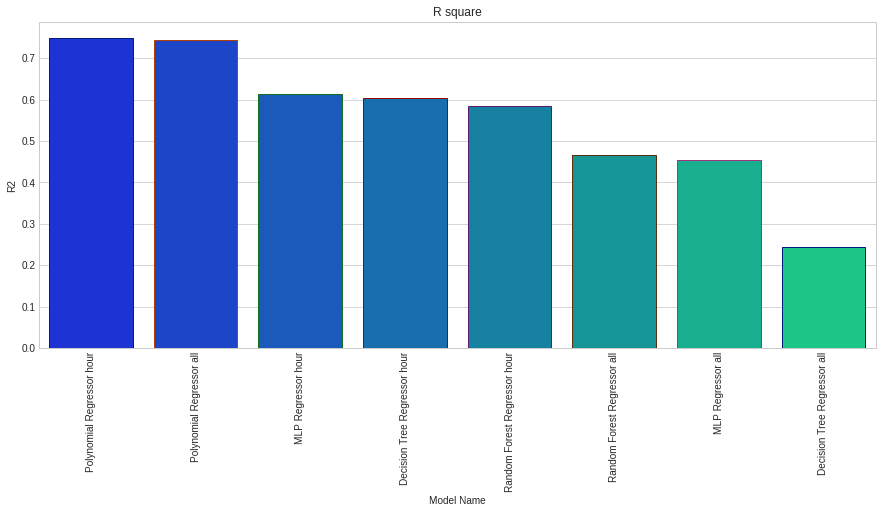

In [162]:
plt.subplots(figsize=(15,6))
sns.barplot(x="Model Name", y="R2",data=model_compare,palette='winter',edgecolor=sns.color_palette('dark',7))
plt.xticks(rotation=90)
plt.title('R square')
plt.show()

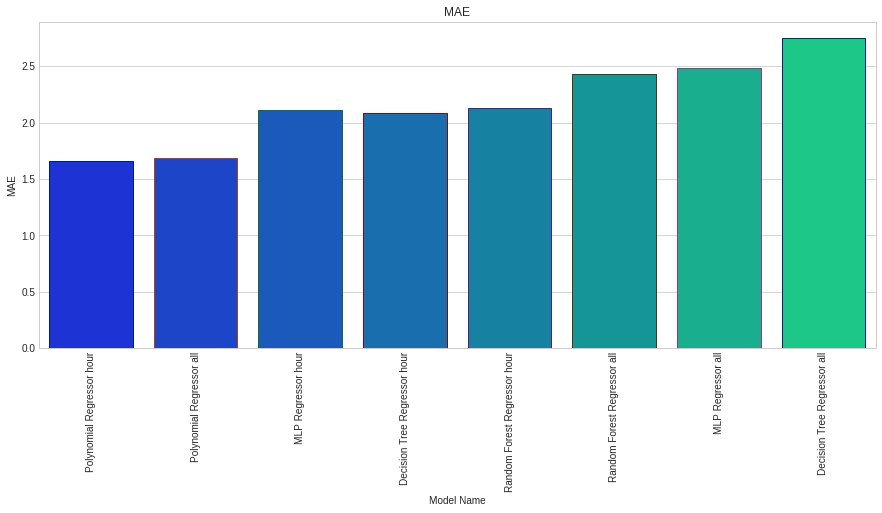

In [163]:
plt.subplots(figsize=(15,6))
sns.barplot(x="Model Name", y="MAE",data=model_compare,palette='winter',edgecolor=sns.color_palette('dark',7))
plt.xticks(rotation=90)
plt.title('MAE')
plt.show()

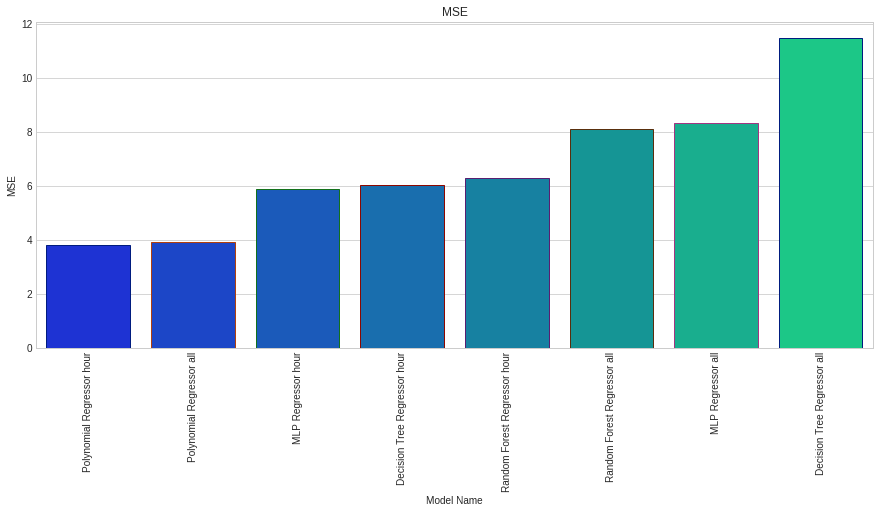

In [164]:
plt.subplots(figsize=(15,6))
sns.barplot(x="Model Name", y="MSE",data=model_compare,palette='winter',edgecolor=sns.color_palette('dark',7))
plt.xticks(rotation=90)
plt.title('MSE')
plt.show()

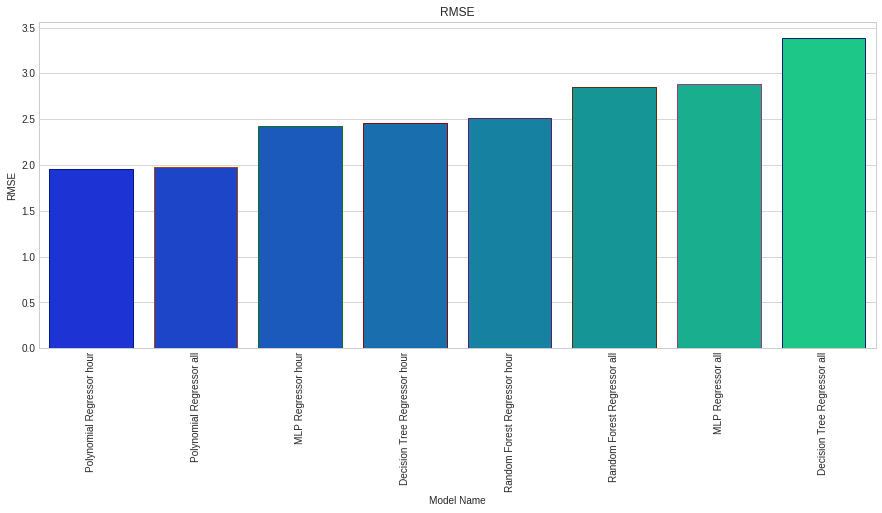

In [165]:
plt.subplots(figsize=(15,6))
sns.barplot(x="Model Name", y="RMSE",data=model_compare,palette='winter',edgecolor=sns.color_palette('dark',7))
plt.xticks(rotation=90)
plt.title('RMSE')
plt.show()

## LSTM

### Data Processing

In [166]:
dataframe = pd.read_csv('dataset.csv', sep=';')

dataframe["Slowness in traffic (%)"] = dataframe["Slowness in traffic (%)"].map(lambda x: x.replace(',', '.')) 
dataframe["Slowness in traffic (%)"] = dataframe["Slowness in traffic (%)"].astype(float)

dataframe

,Hour (Coded),Immobilized bus,Broken Truck,Vehicle excess,Accident victim,Running over,Fire vehicles,Occurrence involving freight,Incident involving dangerous freight,Lack of electricity,Fire,Point of flooding,Manifestations,Defect in the network of trolleybuses,Tree on the road,Semaphore off,Intermittent Semaphore,Slowness in traffic (%)
0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4.1
1,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,6.6
2,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,8.7
3,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,9.2
4,5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,11.1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
130,23,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,17.8
131,24,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,18.1
132,25,1,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,17.7
133,26,0,4,0,0,0,0,0,0,0,0,0,1,0,0,1,0,17.4


In [167]:
lag = 2
# load dataset
dataset = dataframe
values = dataset.values

# integer encode direction
encoder = LabelEncoder()
values[:,4] = encoder.fit_transform(values[:,4])

# ensure all data is float
values = values.astype('float32')

# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)

# frame as supervised learning
reframed = series_to_supervised(scaled, lag, 1)

# drop columns we don't want to predict
reframed.drop(reframed.columns[[-18,-17,-16,-15,-14,-13,-12,-11,-10,-9,-8,-7,-6,-5,-4,-3,-2]], axis=1, inplace=True)
reframed.head()

,var1(t-2),var2(t-2),var3(t-2),var4(t-2),var5(t-2),var6(t-2),var7(t-2),var8(t-2),var9(t-2),var10(t-2),var11(t-2),var12(t-2),var13(t-2),var14(t-2),var15(t-2),var16(t-2),var17(t-2),var18(t-2),var1(t-1),var2(t-1),var3(t-1),var4(t-1),var5(t-1),var6(t-1),var7(t-1),var8(t-1),var9(t-1),var10(t-1),var11(t-1),var12(t-1),var13(t-1),var14(t-1),var15(t-1),var16(t-1),var17(t-1),var18(t-1),var18(t)
2,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.035,0.038462,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.160,0.265
3,0.038462,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.160,0.076923,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.265,0.290
4,0.076923,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.265,0.115385,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.290,0.385
5,0.115385,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.290,0.153846,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.385,0.375
6,0.153846,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.385,0.192308,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.375,0.245


In [168]:
reframed.corr()['var18(t)'].mean()

0.13439599783150907

In [169]:
X = reframed.iloc[:,:-1].copy()
Y = reframed.iloc[:,-1].copy()

X = X.values.reshape((len(X), -1, 18))
print(X[1],Y.iloc[0])


trainX, testX, trainY, testY = train_test_split(X, Y.values, train_size=4/5, shuffle=True)

[[0.03846154 0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.16000001]
 [0.07692309 0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.265     ]] 0.265


### Model

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 2, 18)             0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 2, 18)             72        
_________________________________________________________________
lstm_1 (LSTM)                (None, 512)               1087488   
_________________________________________________________________
batch_normalization_2 (Batch (None, 512)               2048      
_________________________________________________________________
dense_1 (Dense)              (None, 128)               65664     
_________________________________________________________________
batch_normalization_3 (Batch (None, 128)               512       
_________________________________________________________________
batch_normalization_4 (Batch (None, 128)               512 

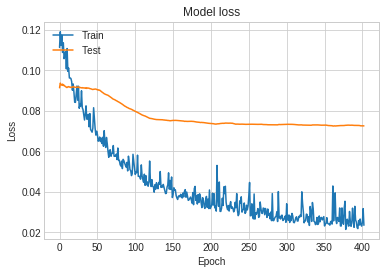

In [170]:
model = Autoencoder()
model.train_model(trainX, trainY, epochs=500, batch_size=50)

#### Evaluation

(106, 2, 18) (106, 1) (106,)
0.031906743


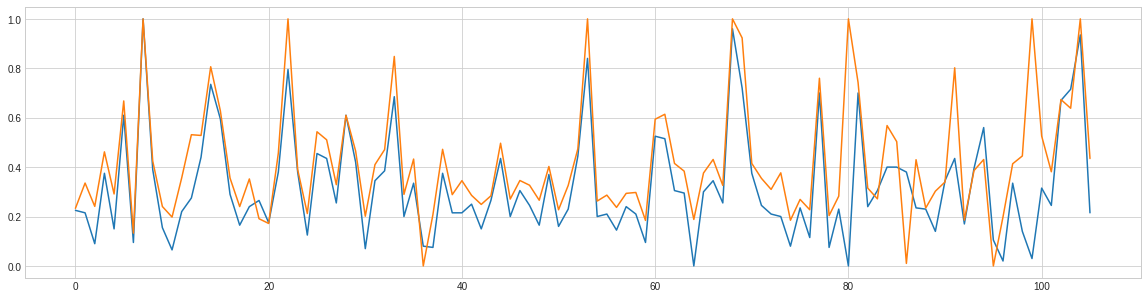

In [171]:
# train results
yhat = model.autoencoder_model.predict(trainX)
print(trainX.shape,yhat.shape,trainY.shape)
reshyhat = np.reshape(yhat,(len(yhat)))
_ = plt.figure(figsize = (20,5))
_ = plt.plot(trainY)
_ = plt.plot(reshyhat)
print(mean_squared_error(trainY, reshyhat))

(27, 2, 18) (27, 1) (27,)
0.021983134


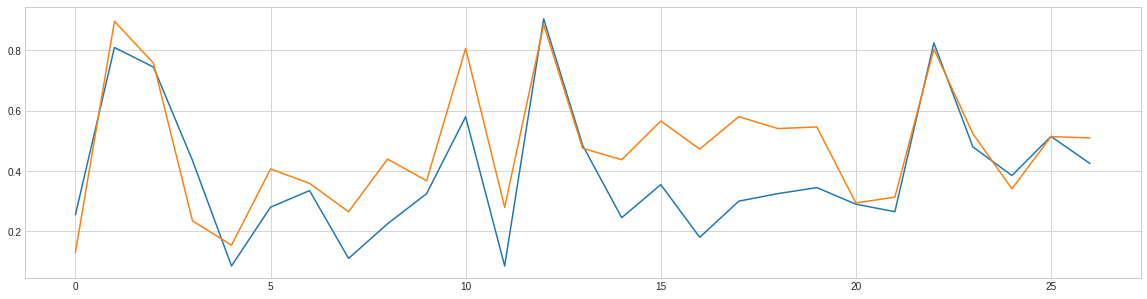

In [172]:
# test results
yhat = model.autoencoder_model.predict(testX)
print(testX.shape,yhat.shape,testY.shape)
reshyhat = np.reshape(yhat,(len(yhat)))
#plt_Y = [testY[i] for i in range(len(testY)) if i not in set(inds-500)]
_ = plt.figure(figsize = (20,5))
_ = plt.plot(testY)
_ = plt.plot(reshyhat)
print(mean_squared_error(testY, reshyhat))

### Load Model

In [173]:
json_file = open('/content/drive/My Drive/Colab Notebooks/Business_traffic/LSTM_p.json', 'r')
loaded_model_json = json_file.read()
load_model = keras.models.model_from_json(loaded_model_json)

#load weights into new model
load_model.load_weights("/content/drive/My Drive/Colab Notebooks/Business_traffic/LSTM_p.h5")
print("Loaded model from disk")

Loaded model from disk


#### Evaluation 

(106, 2, 18) (106, 1) (106,)
0.017805314


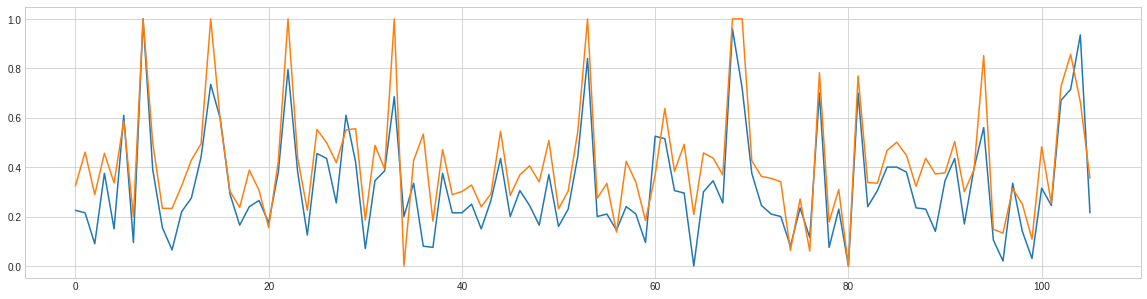

In [174]:
#train
yhat = load_model.predict(trainX)
print(trainX.shape,yhat.shape,trainY.shape)
reshyhat = np.reshape(yhat,(len(yhat)))
_ = plt.figure(figsize = (20,5))
_ = plt.plot(trainY)
_ = plt.plot(reshyhat)
print(mean_squared_error(trainY, reshyhat))

(27, 2, 18) (27, 1) (27,)
0.018329224


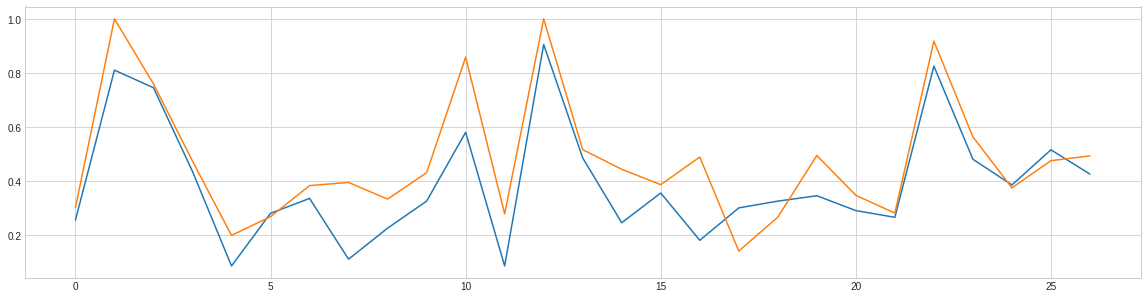

In [175]:
#test
yhat = load_model.predict(testX)
print(testX.shape,yhat.shape,testY.shape)
reshyhat = np.reshape(yhat,(len(yhat)))
_ = plt.figure(figsize = (20,5))
_ = plt.plot(testY)
_ = plt.plot(reshyhat)
print(mean_squared_error(testY, reshyhat))

In [176]:
optimizer = keras.optimizers.Adam(lr=0.000005)
load_model.compile(loss='mse', optimizer=optimizer, metrics=['mse'])
score = load_model.evaluate(testX, testY, verbose=0)
print("%s: %.2f%%" % (load_model.metrics_names[1], score[1]*100))

mean_squared_error: 1.83%


### Save Model

In [0]:
model_json = model.autoencoder_model.to_json()
with open("/content/drive/My Drive/Colab Notebooks/Business_traffic/LSTM.json", "w") as json_file:
    json_file.write(model_json)
  
#serialize weights to HDF5
model.autoencoder_model.save_weights("/content/drive/My Drive/Colab Notebooks/Business_traffic/LSTM.h5")
print("Saved model to disk")